## Step 1: Define Bravais Lattice Vectors

Let the Bravais lattice vectors be:
$$
\vec{a}_1 = \begin{bmatrix} a_{11} \\ a_{12} \end{bmatrix}, \quad
\vec{a}_2 = \begin{bmatrix} a_{21} \\ a_{22} \end{bmatrix}
$$

We define the transformation matrix:
$$
A = \begin{bmatrix} \vec{a}_1 & \vec{a}_2 \end{bmatrix}
= \begin{bmatrix}
a_{11} & a_{21} \\
a_{12} & a_{22}
\end{bmatrix}
$$

In the code below,
- $\vec{a}_1$: `a1: np.ndarray`
- $\vec{a}_2$: `a2: np.ndarray`
- $A$: `A: np.ndarray` 

In [77]:
import numpy as np

hbar = 1.
m = 1.

a1: np.ndarray = np.array([1.0, 0.0])
a2: np.ndarray = np.array([0.5, np.sqrt(3)/2])
A: np.ndarray = np.column_stack((a1, a2))

In [78]:
print(f"a1:{a1}")
print(f"a2:{a2}")
print(f"A:\n:{A}")

assert isinstance(a1, np.ndarray)
assert isinstance(a2, np.ndarray)
assert isinstance(A, np.ndarray)
print(f"a1.shape:{a1.shape}")
print(f"a2.shape:{a2.shape}")
print(f"A.shape:{A.shape}")
assert a1.shape == (2,)
assert a2.shape == (2,)
assert A.shape == (2,2)

a1:[1. 0.]
a2:[0.5       0.8660254]
A:
:[[1.        0.5      ]
 [0.        0.8660254]]
a1.shape:(2,)
a2.shape:(2,)
A.shape:(2, 2)


# Calculate the metric tensor $G$
To express the Laplacian in curvilinear coordinates, we compute the **metric tensor**:
$$
G = A^\mathrm{T} A
\quad \text{where} \quad
A = [\vec{a}_1 \; \vec{a}_2]
$$

This tensor encodes the inner products between the basis vectors:
$$
G =
\begin{bmatrix}
\vec{a}_1 \cdot \vec{a}_1 & \vec{a}_1 \cdot \vec{a}_2 \\
\vec{a}_2 \cdot \vec{a}_1 & \vec{a}_2 \cdot \vec{a}_2
\end{bmatrix}
$$

To write the Laplacian in these coordinates, we use:
$$
\nabla^2 = \nabla_{\xi}^\mathrm{T} \, G^{-1} \, \nabla_{\xi}
\quad \text{with} \quad \xi = (u, v)
$$


In [79]:
G = A.T @ A
Ginv = np.linalg.inv(G)
print("G = \n",G)
print("Ginv = \n", Ginv)


G = 
 [[1.  0.5]
 [0.5 1. ]]
Ginv = 
 [[ 1.33333333 -0.66666667]
 [-0.66666667  1.33333333]]


## Build the Laplacian in Curvilinear Coordinates
We solve the time-independent Schrödinger equation:
$$
- \frac{\hbar^2}{2m} \nabla^2 \psi = E \psi
$$

After the coordinate transformation $\vec{r} = A \vec{\xi}$, the Laplacian becomes:
$$
\nabla^2 = \nabla_\xi^\mathrm{T} G^{-1} \nabla_\xi
= G^{11} \frac{\partial^2}{\partial u^2}
+ G^{22} \frac{\partial^2}{\partial v^2}
+ G^{12} \frac{\partial^2}{\partial u \partial v}
$$

This is a constant-coefficient differential operator on the unit square.

### Discretization on a Uniform Grid
Let:
- $(u_i, v_j) \in [0, 1]^2$, with spacing $h$
- $\psi[i, j]$ be the value of the wavefunction at each grid point

Use second-order central differences:

- Second derivative in $u$:
  $$
  D_{uu} \psi[i,j] \approx \frac{\psi[i+1,j] - 2\psi[i,j] + \psi[i-1,j]}{h^2}
  $$

- Second derivative in $v$:
  $$
  D_{vv} \psi[i,j] \approx \frac{\psi[i,j+1] - 2\psi[i,j] + \psi[i,j-1]}{h^2}
  $$

- Mixed partial $\frac{\partial^2}{\partial u \partial v}$:
  $$
  D_{uv} \psi[i,j] \approx \frac{
    \psi[i+1,j+1] - \psi[i+1,j-1]
    - \psi[i-1,j+1] + \psi[i-1,j-1]
  }{4h^2}
  $$
### Final Discrete Laplacian
$$
(\nabla^2 \psi)[i,j] \approx
G^{11} D_{uu} \psi[i,j] +
G^{22} D_{vv} \psi[i,j] +
2G^{12} D_{uv} \psi[i,j]
$$

This operator will be used to build the finite-difference Hamiltonian matrix.



In [80]:
"""Apply Laplacian using metric tensor inverse Ginv on grid psi"""
import scipy.sparse
def get_laplacian_1d(N, h):
    diag_main =  -2 * np.ones(N)
    diag_off = 1 * np.ones(N-1)
    return scipy.sparse.diags(
        [diag_off, diag_main, diag_off],
        [-1,0,1]
    ) / (h**2)

def get_1st_derivative_operator(N, h):
    """
    Construct central difference matrix for first derivative d/dx
    with Dirichlet boundary conditions.
    """
    data = [-0.5 * np.ones(N - 1), 0.5 * np.ones(N - 1)]
    offsets = [-1, 1]
    return scipy.sparse.diags(data, offsets) / h

N: int = 50
h:float = 1.
Ginv_11: float = Ginv[0,0] 
Ginv_12: float = Ginv[0,1]
Ginv_22: float = Ginv[1,1]

Du = get_1st_derivative_operator(N, h)
Dv = get_1st_derivative_operator(N, h)
Duu = get_laplacian_1d(N, h)
Dvv = get_laplacian_1d(N, h)
Duv = scipy.sparse.kron(Du, Dv)
I = scipy.sparse.eye(N)

laplacian_uv = Ginv_11 * scipy.sparse.kron(Duu, I) \
    + Ginv_22 *  scipy.sparse.kron(I, Dvv) \
    + 2*Ginv_12 * Duv


In [81]:
Hhat_uv = - (hbar**2) / (2 * m) * laplacian_uv

In [82]:
from scipy.sparse.linalg import eigsh

eigen_N = 20  # or however many you want
# Smallest Magnitude eigenvalues
# note: eigen_E = eugen_E_uv because Ginv encodes physical geometry
eigen_E, eigen_psi_uv = eigsh(Hhat_uv, k=eigen_N, which='SM')


In [83]:
print(f"eigen_E:{eigen_E}")

eigen_E:[0.00478672 0.01011874 0.01377473 0.01612697 0.0235731  0.02364693
 0.02694729 0.03260918 0.03261255 0.04046434 0.04382281 0.04387602
 0.0448104  0.05132492 0.05596911 0.05628007 0.06375416 0.06437351
 0.06732753 0.07082623]


In [84]:
u = np.linspace(0, 1, N)
v = np.linspace(0, 1, N)
U, V = np.meshgrid(u ,v, indexing='ij')

UV = np.stack([U.ravel(), V.ravel()], axis=0)
XY = A @ UV

x = XY[0].reshape((N,N))
y = XY[1].reshape((N,N))
eigen_psi = [eigen_psi_uv[:, i].reshape((N, N)) for i in range(eigen_N)]


# Calculating the probability density
$$
P(x,y) = \Psi(x,y)^* \Psi(x,y)
$$

which is a joint probability distribution with respect to $x$, and $y$

In [85]:
import matplotlib.pyplot as plt
def plot_probability_density(x, y, psi, E=None, index=None, cmap='viridis'):
    """
    Visualize the probability density |ψ(x,y)|² on the real-space grid.
    
    Parameters:
    - x, y: (N, N) arrays of real-space coordinates
    - psi: (N, N) array, the wavefunction ψ(x, y)
    - E: optional, energy value to display
    - index: optional, eigenstate index
    - cmap: colormap
    """
    prob_density = np.abs(psi)**2

    plt.figure(figsize=(5, 4))
    plt.pcolormesh(x, y, prob_density, shading='auto', cmap=cmap)
    plt.gca().set_aspect('equal')
    title = ""
    if index is not None:
        title += f"ψ[{index}] "
    if E is not None:
        title += f"E = {E:.4f}"
    plt.title(title)
    plt.colorbar(label=r"$|\psi(x,y)|^2$")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.show()

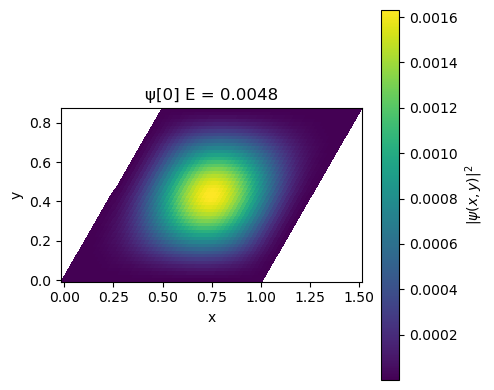

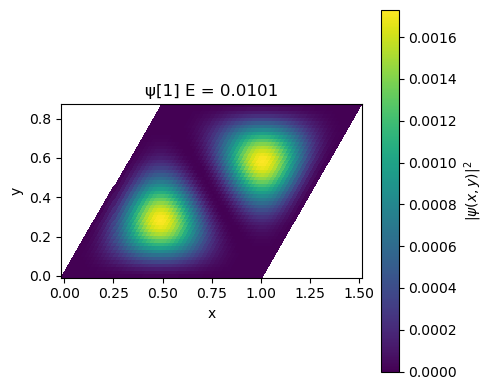

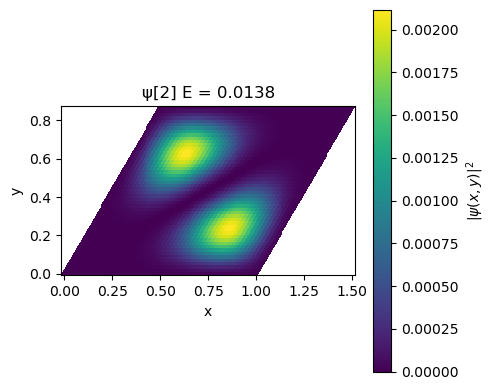

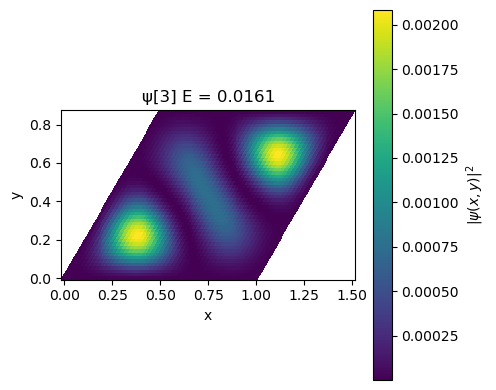

In [86]:
for i in range(4):
    plot_probability_density(x, y, eigen_psi[i], E=eigen_E[i], index=i)

# Now solve in $k$-space
Given $\mathbf{a}_1, \mathbf{a}_2$ creating
$$
    A = \begin{bmatrix}\mathbf{a}_1 & \mathbf{a}_2\end{bmatrix}
$$
Then
$$
    B 
    = 2 \pi(A^{-1})^T 
    = \begin{bmatrix}\mathbf{b}_1 & \mathbf{b}_2\end{bmatrix}
$$

[ 6.28318531 -3.62759873]
[0.         7.25519746]


In [ ]:
m1_max = 5
m2_max = 5
eigen_N_G = 20

# Integer ranges
G_max = 5
m1, m2 = np.meshgrid(
    np.arange(-G_max, G_max+1), 
    np.arange(-G_max, G_max+1), 
    indexing='ij')
m_flat = np.stack(
    [m1.ravel(), m2.ravel()], 
    axis=0)  # shape (2, N^2)

# Compute G_points = B_mat @ [m1, m2]
G_points = B @ m_flat  # shape (2, N^2)
G_points = G_points.T      # shape (N^2, 2)

# sort by |G|^2 norm
G_norm2 = np.sum(G_points**2, axis=1)
sorted_idx = np.argsort(G_norm2)

G_points = G_points[sorted_idx]
G_norm2 = G_norm2[sorted_idx]

# Build Kinetic Hamiltonian in Plane Wave Basis 
# Compute kinetic energy
hbar = 1.0
mass = 1.0
G_norm2 = np.sum(G_points**2, axis=1)
KEhat = (hbar**2 / (2 * mass)) * G_norm2

# Build Hamiltonian and diagonalize
Hhat_G = scipy.sparse.diags(KEhat)
print(Hhat_G)
eigen_E_G, eigen_phi_G = eigsh(
    Hhat_G, k=eigen_N_G, which='SM')

print(eigen_E_G)


<DIAgonal sparse matrix of dtype 'float64'
	with 121 stored elements (1 diagonals) and shape (121, 121)>
  Coords	Values
  (1, 1)	26.318945069571622
  (2, 2)	26.318945069571622
  (3, 3)	26.318945069571622
  (4, 4)	26.318945069571622
  (5, 5)	26.31894506957163
  (6, 6)	26.31894506957163
  (7, 7)	78.95683520871486
  (8, 8)	78.95683520871486
  (9, 9)	78.95683520871488
  (10, 10)	78.95683520871488
  (11, 11)	78.95683520871488
  (12, 12)	78.95683520871488
  (13, 13)	105.27578027828649
  (14, 14)	105.27578027828649
  (15, 15)	105.27578027828649
  (16, 16)	105.27578027828649
  (17, 17)	105.27578027828652
  (18, 18)	105.27578027828652
  (19, 19)	184.23261548700137
  (20, 20)	184.23261548700137
  (21, 21)	184.23261548700137
  (22, 22)	184.23261548700137
  (23, 23)	184.2326154870014
  (24, 24)	184.2326154870014
  (25, 25)	184.2326154870014
  :	:
  (96, 96)	736.9304619480057
  (97, 97)	815.8872971567205
  (98, 98)	815.8872971567205
  (99, 99)	815.8872971567205
  (100, 100)	815.8872971567205
  (10

## Reconstruct Real-Space Wavefunctions from Reciprocal Space Coefficients

Given the eigenvectors in reciprocal space, `eigen_phi_G` (shape `(num_G, num_modes)`), reconstruct the real-space wavefunctions $ \psi_i(x, y)$ as:

$$
\psi_i(x, y) = \sum_{\mathbf{G}} \phi_i(\mathbf{G}) \, e^{i \mathbf{G} \cdot \mathbf{r}}
$$

In [94]:
import numpy as np

def reconstruct_real_space_wavefunctions(eigen_phi_G, G_points, X, Y, cell_area):
    """
    Reconstruct real-space wavefunctions from reciprocal-space coefficients.

    Parameters:
    - eigen_phi_G: np.ndarray, shape (num_G, num_modes)
        Coefficients of eigenmodes in G-space (plane wave basis).
    - G_points: np.ndarray, shape (num_G, 2)
        Reciprocal lattice vectors corresponding to eigen_phi_G rows.
    - X, Y: np.ndarray, shape (Nx, Ny)
        Real-space meshgrid coordinate arrays.
    - cell_area: float
        Area of the real-space unit cell for normalization.

    Returns:
    - psi_real_space: np.ndarray, shape (num_modes, Nx, Ny)
        Complex-valued real-space wavefunctions.
    """
    num_modes = eigen_phi_G.shape[1]
    Nx, Ny = X.shape
    psi_real_space = np.zeros((num_modes, Nx, Ny), dtype=complex)

    for i in range(num_modes):
        phi_i = eigen_phi_G[:, i]
        psi_i = np.zeros_like(X, dtype=complex)
        for coeff, G in zip(phi_i, G_points):
            psi_i += coeff * np.exp(1j * (G[0]*X + G[1]*Y))
        psi_real_space[i] = psi_i / np.sqrt(cell_area)

    return psi_real_space

# Given lattice vectors a1, a2, form matrix A
A = np.column_stack((a1, a2))

# Create fractional grid (u, v) over unit square
Nu, Nv = 100, 100
u = np.linspace(0, 1, Nu)
v = np.linspace(0, 1, Nv)
U, V = np.meshgrid(u, v, indexing='ij')

# Map fractional coords to real space
XY = A @ np.stack([U.ravel(), V.ravel()], axis=0)
X = XY[0].reshape(Nu, Nv)
Y = XY[1].reshape(Nu, Nv)

# Compute unit cell area
cell_area = np.abs(np.linalg.det(A))

# Now reconstruct wavefunctions
psi_modes = reconstruct_real_space_wavefunctions(eigen_phi_G, G_points, X, Y, cell_area)


# plot them

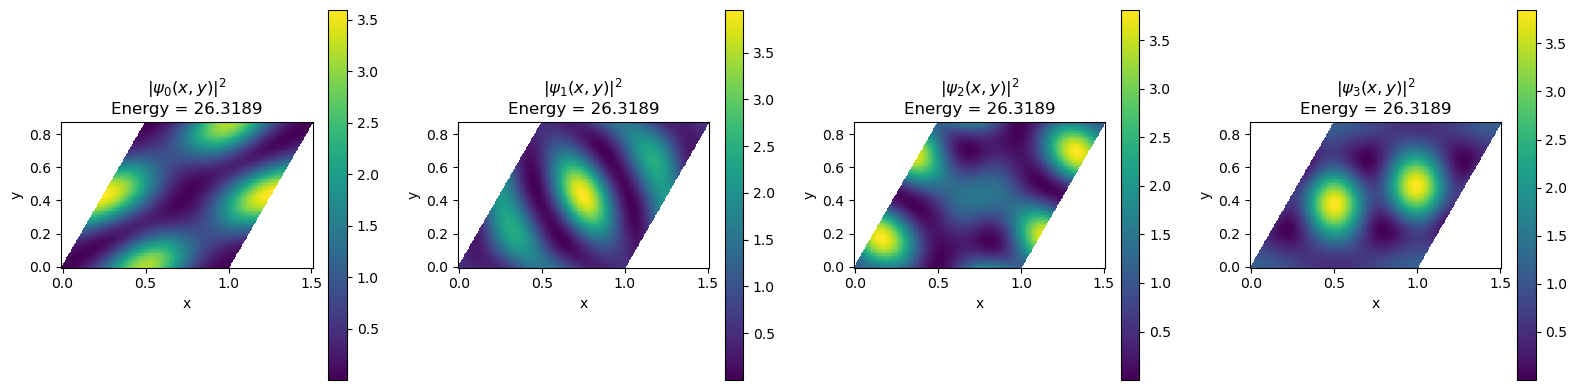

In [96]:
import matplotlib.pyplot as plt

num_plot = min(4, psi_modes.shape[0])  # number of modes to plot

fig, axes = plt.subplots(1, num_plot, figsize=(4 * num_plot, 4))

for i in range(num_plot):
    ax = axes[i] if num_plot > 1 else axes
    im = ax.pcolormesh(X, Y, np.abs(psi_modes[i])**2, shading='auto', cmap='viridis')
    energy = eigen_E_G[i]
    ax.set_title(f'$|\\psi_{{{i}}}(x,y)|^2$\nEnergy = {energy:.4f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()


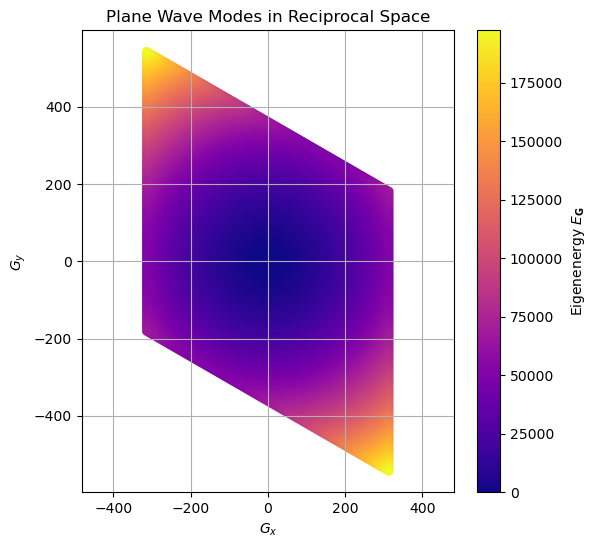

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
sc = plt.scatter(G_points[:, 0], G_points[:, 1], c=eigen_E, cmap='plasma', s=30)
plt.colorbar(sc, label="Eigenenergy $E_{\\mathbf{G}}$")
plt.xlabel(r"$G_x$")
plt.ylabel(r"$G_y$")
plt.title("Plane Wave Modes in Reciprocal Space")
plt.axis('equal')
plt.grid(True)
plt.show()
    

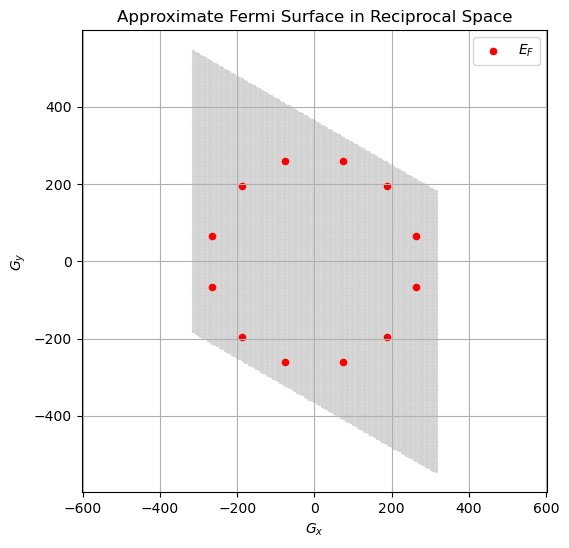

In [ ]:
EF = np.median(eigen_E)  # or set manually
mask = np.isclose(eigen_E, EF, atol=10)  # small shell

plt.figure(figsize=(6, 6))
plt.scatter(G_points[:, 0], G_points[:, 1], c='lightgray', s=2)
plt.scatter(G_points[mask, 0], G_points[mask, 1], c='red', s=20, label=r"$E_F$")
plt.legend()
plt.xlabel(r"$G_x$")
plt.ylabel(r"$G_y$")
plt.title("Approximate Fermi Surface in Reciprocal Space")
plt.axis('equal')
plt.grid(True)
plt.show()


Lowest kinetic energies (eigenvalues):
[ 19.7392088   19.7392088   24.674011    24.674011    24.674011
  24.674011    64.15242861  64.15242861  64.15242861  64.15242861
  78.95683521  78.95683521  78.95683521  78.95683521  98.69604401
  98.69604401  98.69604401  98.69604401 143.10926382 143.10926382]


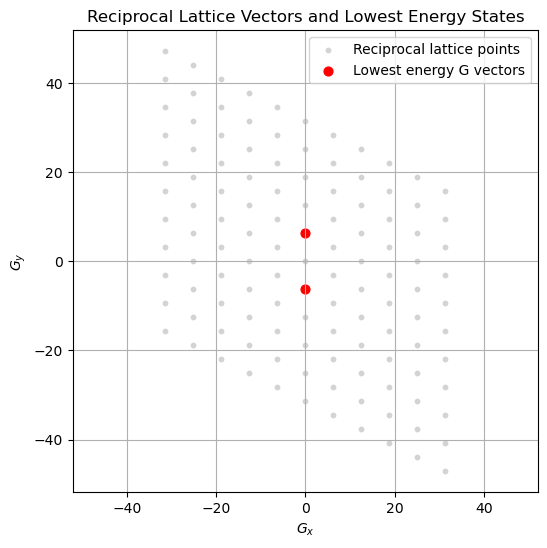

In [97]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

# Define direct lattice vectors (example: non-orthogonal lattice)
a1 = np.array([1.0, 0.0])
a2 = np.array([0.5, 1.0])
A = np.column_stack((a1, a2))

# Compute reciprocal lattice matrix B
B = 2 * np.pi * np.linalg.inv(A).T  # shape (2,2)

# Generate reciprocal lattice vectors G = B * (m1, m2)
G_max = 5
m1, m2 = np.meshgrid(np.arange(-G_max, G_max+1), np.arange(-G_max, G_max+1), indexing='ij')
m_flat = np.stack([m1.ravel(), m2.ravel()], axis=0)  # shape (2, N)

G_points = (B @ m_flat).T  # shape (N, 2)

# Compute squared norm |G|^2 (Euclidean norm in Cartesian coords)
G_norm2 = np.sum(G_points**2, axis=1)

# Build kinetic energy diagonal: E = (hbar^2 / 2m) * |G|^2
hbar = 1.0
mass = 1.0
KE = (hbar**2) / (2 * mass) * G_norm2

# Create diagonal Hamiltonian matrix
Hhat = sp.diags(KE)

# Compute lowest eigenvalues and eigenvectors
num_eigen = 20
eigen_E, eigen_phi = eigsh(Hhat, k=num_eigen, which='SM')

# Sort eigenvalues for display
idx_sort = np.argsort(eigen_E)
eigen_E = eigen_E[idx_sort]

print("Lowest kinetic energies (eigenvalues):")
print(eigen_E)

# Plot reciprocal lattice points and highlight points near lowest eigenvalues
plt.figure(figsize=(6,6))
plt.scatter(G_points[:,0], G_points[:,1], c='lightgray', s=10, label='Reciprocal lattice points')

# Mark points with kinetic energy near smallest eigenvalue (within tolerance)
tol = 1e-5
lowest_E = eigen_E[0]
mask = np.abs(KE - lowest_E) < tol
plt.scatter(G_points[mask,0], G_points[mask,1], c='red', s=40, label='Lowest energy G vectors')

plt.xlabel(r'$G_x$')
plt.ylabel(r'$G_y$')
plt.title('Reciprocal Lattice Vectors and Lowest Energy States')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


Gamma index: 60
Gamma vector G: [0. 0.]
Lowest kinetic energies:
[ 19.7392088   19.7392088   24.674011    24.674011    24.674011
  24.674011    64.15242861  64.15242861  64.15242861  64.15242861
  78.95683521  78.95683521  78.95683521  78.95683521  98.69604401
  98.69604401  98.69604401  98.69604401 143.10926382 143.10926382]


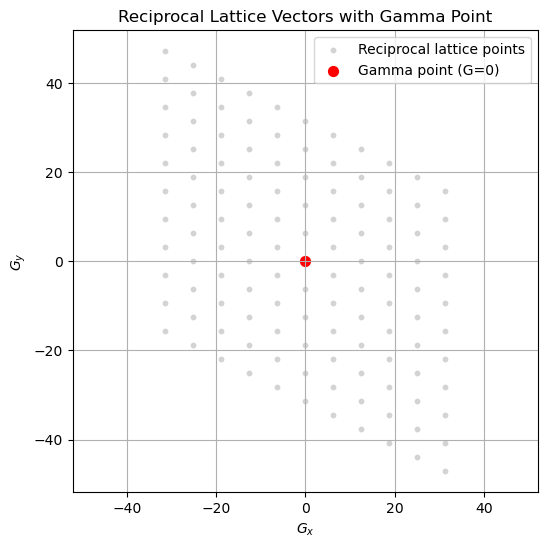

In [98]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

# Define direct lattice vectors (example)
a1 = np.array([1.0, 0.0])
a2 = np.array([0.5, 1.0])
A = np.column_stack((a1, a2))

# Reciprocal lattice matrix B
B = 2 * np.pi * np.linalg.inv(A).T  # shape (2,2)

# Set G_max large enough to include zero vector explicitly
G_max = 5
m1, m2 = np.meshgrid(
    np.arange(-G_max, G_max + 1),
    np.arange(-G_max, G_max + 1),
    indexing='ij'
)
m_flat = np.stack([m1.ravel(), m2.ravel()], axis=0)  # shape (2, N)

# Compute reciprocal vectors
G_points = (B @ m_flat).T  # shape (N, 2)

# Confirm Gamma point included
zero_idx = np.where((m_flat == 0).all(axis=0))[0][0]
print("Gamma index:", zero_idx)
print("Gamma vector G:", G_points[zero_idx])

# Compute squared norm
G_norm2 = np.sum(G_points**2, axis=1)

# Compute kinetic energy
hbar = 1.0
mass = 1.0
KE = (hbar**2) / (2 * mass) * G_norm2

# Build Hamiltonian diagonal and solve eigenproblem
Hhat = sp.diags(KE)
num_eigen = 20
eigen_E, eigen_phi = eigsh(Hhat, k=num_eigen, which='SM')

print("Lowest kinetic energies:")
print(eigen_E)

# Plot reciprocal lattice points and highlight Gamma
plt.figure(figsize=(6,6))
plt.scatter(G_points[:,0], G_points[:,1], c='lightgray', s=10, label='Reciprocal lattice points')
plt.scatter(G_points[zero_idx, 0], G_points[zero_idx, 1], c='red', s=50, label='Gamma point (G=0)')
plt.xlabel(r'$G_x$')
plt.ylabel(r'$G_y$')
plt.title('Reciprocal Lattice Vectors with Gamma Point')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


In [99]:
print(f"Gamma point kinetic energy: {KE[zero_idx]}")  # Should be 0 or near 0
print(f"Lowest eigenenergy from eigsh: {eigen_E[0]}")  # Should match Gamma point energy


Gamma point kinetic energy: 0.0
Lowest eigenenergy from eigsh: 19.739208802178737


In [106]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh

# Build G_points including Gamma point (0,0)
G_max = 5
m1, m2 = np.meshgrid(
    np.arange(-G_max, G_max + 1),
    np.arange(-G_max, G_max + 1),
    indexing='ij'
)
m_flat = np.stack([m1.ravel(), m2.ravel()], axis=0)
# Define direct lattice vectors (example)
a1 = np.array([1.0, 0.0])
a2 = np.array([0.5, 1.0])
A = np.column_stack((a1, a2))

# Reciprocal lattice matrix B
B = 2 * np.pi * np.linalg.inv(A).T  # shape (2,2)

G_points = B @ m_flat
G_points = G_points.T

# Sort by norm squared
G_norm2 = np.sum(G_points**2, axis=1)
sorted_idx = np.argsort(G_norm2)
G_points = G_points[sorted_idx]
G_norm2 = G_norm2[sorted_idx]

# Kinetic energy operator
hbar = 1.0
mass = 1.0
KEhat = (hbar ** 2) / (2 * mass) * G_norm2

# Sparse diagonal Hamiltonian
Hhat_G = sp.diags(KEhat)

print(f"Gamma kinetic energy (should be 0): {KEhat[0]}")
print(f"Diagonal entries shape: {Hhat_G.shape}")

# Compute eigenvalues using eigsh
from scipy.linalg import eigh

eigen_E, eigen_phi = eigh(Hhat_G.toarray())
print(f"Lowest eigenvalues: {eigen_E}")


Gamma kinetic energy (should be 0): 0.0
Diagonal entries shape: (121, 121)
Lowest eigenvalues: [   0.           19.7392088    19.7392088    24.674011     24.674011
   24.674011     24.674011     64.15242861   64.15242861   64.15242861
   64.15242861   78.95683521   78.95683521   78.95683521   78.95683521
   98.69604401   98.69604401   98.69604401   98.69604401  143.10926382
  143.10926382  143.10926382  143.10926382  157.91367042  157.91367042
  157.91367042  157.91367042  177.65287922  177.65287922  182.58768142
  182.58768142  182.58768142  182.58768142  222.06609902  222.06609902
  222.06609902  222.06609902  256.60971443  256.60971443  256.60971443
  256.60971443  261.54451663  261.54451663  261.54451663  261.54451663
  301.02293423  301.02293423  301.02293423  301.02293423  315.82734083
  315.82734083  315.82734083  315.82734083  335.56654964  335.56654964
  335.56654964  335.56654964  394.78417604  394.78417604  394.78417604
  394.78417604  394.78417604  394.78417604  394.7841760

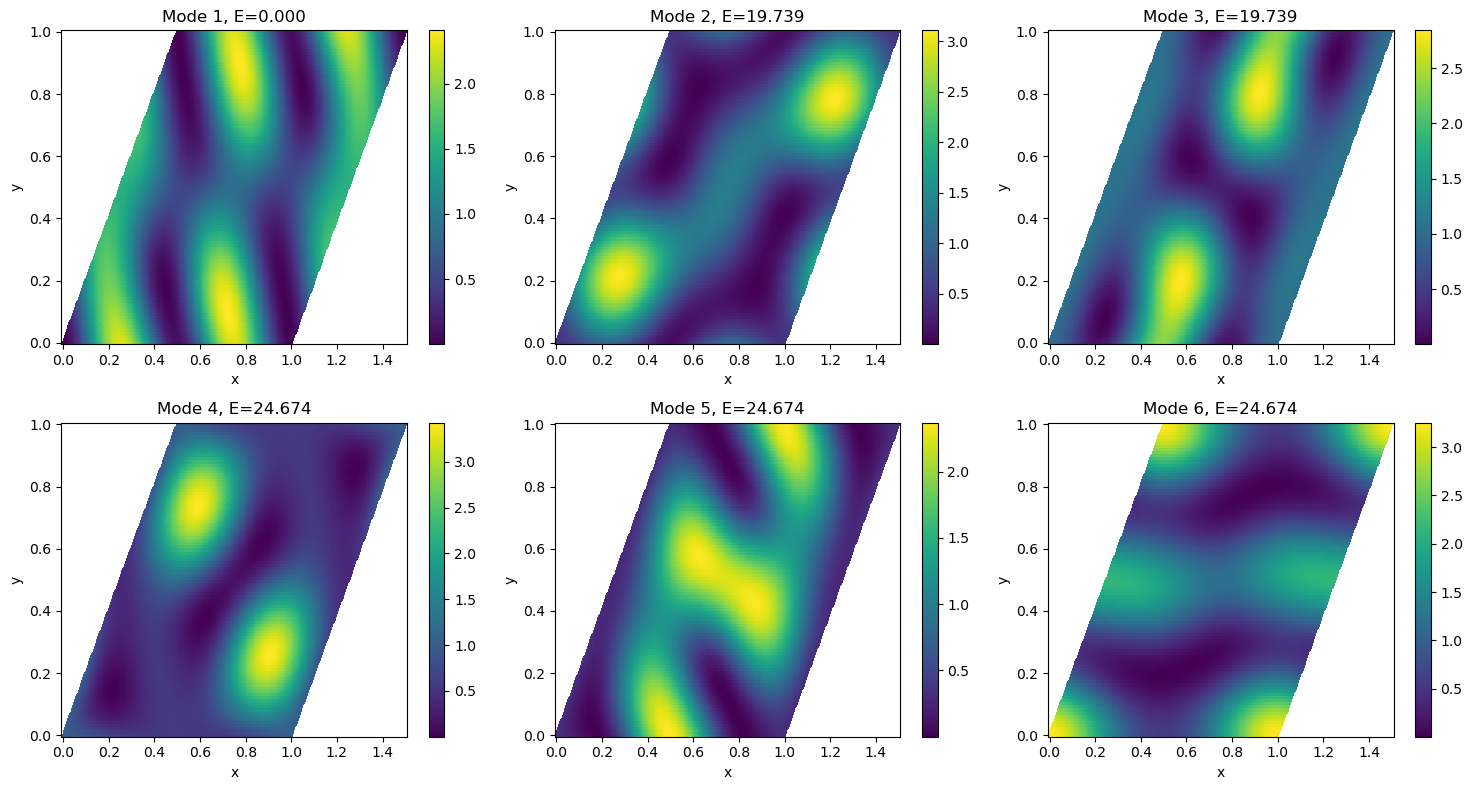

In [107]:
import numpy as np
import matplotlib.pyplot as plt

def reconstruct_real_space_wavefunctions(eigen_phi_G, G_points, X, Y, cell_area):
    num_modes = eigen_phi_G.shape[1]
    Nx, Ny = X.shape
    psi_real_space = np.zeros((num_modes, Nx, Ny), dtype=complex)

    for i in range(num_modes):
        phi_i = eigen_phi_G[:, i]
        psi_i = np.zeros_like(X, dtype=complex)
        for coeff, G in zip(phi_i, G_points):
            psi_i += coeff * np.exp(1j * (G[0]*X + G[1]*Y))
        psi_real_space[i] = psi_i / np.sqrt(cell_area)
    return psi_real_space

# Assuming you have:
# a1, a2 -- direct lattice vectors (2D np.array)
# eigen_phi_G -- shape (num_G, num_modes) complex coefficients
# G_points -- reciprocal lattice vectors shape (num_G, 2)
# eigen_E -- eigenvalues
# You can create a real-space grid:

A = np.column_stack((a1, a2))
Nu, Nv = 100, 100
u = np.linspace(0, 1, Nu)
v = np.linspace(0, 1, Nv)
U, V = np.meshgrid(u, v, indexing='ij')

XY = A @ np.stack([U.ravel(), V.ravel()], axis=0)
X = XY[0].reshape(Nu, Nv)
Y = XY[1].reshape(Nu, Nv)

cell_area = np.abs(np.linalg.det(A))

# Reconstruct eigenfunctions in real space
psi_real_space = reconstruct_real_space_wavefunctions(eigen_phi_G, G_points, X, Y, cell_area)

# Plot first few eigenfunctions |psi|^2
num_plots = min(6, psi_real_space.shape[0])
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.flatten()

for i in range(num_plots):
    ax = axs[i]
    im = ax.pcolormesh(X, Y, np.abs(psi_real_space[i])**2, shading='auto')
    ax.set_title(f"Mode {i+1}, E={eigen_E[i]:.3f}")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()



In [108]:
ok cool.

SyntaxError: invalid syntax (693233914.py, line 1)